In [405]:
import pandas as pd
import os
import time

# work with directories
from pathlib import Path 

# datetime
#import datetime as dt
from datetime import datetime
from dateutil.relativedelta import relativedelta

# work with data
import numpy as np

# visualize data
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

# create bag of word vector
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation as LDA

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sktime.forecasting.arima import ARIMA, AutoARIMA

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_validate

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

## Import data & generate features

### Import data
- combine the merged frame of GDLET event counts and UCDP deaths with World Bank population data
- remove countries
    - with few GDELT entries
    - with no population data
- Next steps:
    - find better way of imputing missing population data for 2022 and 2023 (currently just using 2021)
    - find alternative population count sources for some countries, especially Western Sahara and Palestine

In [406]:
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

merged_og = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))
wb_pop_og = pd.read_csv(os.path.abspath(parent_path + '/data/WorldBank_pop/wb_pop.csv'), sep=';')

print('countires with pop data: ',wb_pop_og['Country Code'].nunique())
print('countires in merged data: ',merged_og['isocode'].nunique())

countires with pop data:  266
countires in merged data:  240


In [407]:
merged = merged_og.copy()
merged = merged[merged['year'] >= 1989]

# Because of issue with MonthYear column: create new column with year and month
merged['year'] = merged['year'].astype(str)
merged['month'] = merged['month'].astype(str)

# Pad the month column with leading zeros if needed (e.g., convert '1' to '01')
merged['month'] = merged['month'].str.zfill(2)

# Concatenate the year and month columns with a '-' &  convert to datetime object
merged['month_year'] = merged['year'] + '-' + merged['month']
merged['month_year'] = pd.to_datetime(merged['month_year'], format='%Y-%m')


# compare month_year and MonthYear
merged.MonthYear = pd.to_datetime(merged.MonthYear)

print('entires merged:', len(merged))
print('date range:', merged.month_year.min(), 'to', merged.month_year.max())
print('date range:', merged.MonthYear.min(), 'to', merged.MonthYear.max())

merged[['month_year', 'MonthYear']].head(3)

entires merged: 92637
date range: 1989-01-01 00:00:00 to 2023-05-01 00:00:00
date range: 1970-01-01 00:00:00.000198901 to 1970-01-01 00:00:00.000202305


,month_year,MonthYear
23666,1989-01-01,1970-01-01 00:00:00.000198901
23667,1989-01-01,1970-01-01 00:00:00.000198901
23668,1989-01-01,1970-01-01 00:00:00.000198901


In [408]:
pop = wb_pop_og.copy()
pop.drop(columns=['Unnamed: 67', '2022', 'Indicator Name', 'Indicator Code'], inplace=True)

# fill missing years
pop['2022'] = pop['2021']
pop['2023'] = pop['2021']

# melt population data
pop = pd.melt(pop, id_vars=('Country Code', 'Country Name'), var_name='Year', value_name='wb_pop')

pop.rename(columns={'Country Code': 'isocode'}, inplace=True)
pop.rename(columns={'Year': 'year'}, inplace=True)
pop = pop[pop['year'] >= '1989']

In [409]:
import pycountry as pc

missing_pop_data = set(merged.isocode.unique()) - set(pop.isocode.unique())

for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)

Tokelau
Falkland Islands (Malvinas)
Saint Pierre and Miquelon
Holy See (Vatican City State)
Mayotte
Svalbard and Jan Mayen
Cook Islands
Anguilla
Niue
Heard Island and McDonald Islands
Guernsey
Guadeloupe
Christmas Island
Saint Helena, Ascension and Tristan da Cunha
Jersey
Western Sahara
Bouvet Island
Norfolk Island
Wallis and Futuna
Pitcairn
Montserrat
French Guiana
British Indian Ocean Territory
Antarctica
Martinique
Réunion
Taiwan, Province of China


In [410]:
df_merged = pd.merge(merged, pop, on=['isocode', 'year'], how='left')

# drop countries with with <413 Month Entries in GDELT
# exception: 'SSD'
isocodes_to_drop = ['ABW', 'AIA', 'AND', 'ASM', 'BVT', 'COK', 'CXR', 'CYM', 'FLK', 'FRO', 'GGY', 'GLP', 'GUF', 'HMD', 'IMN', 'IOT', 'KIR', 'KNA', 'LCA', 'LIE', 'MTQ', 'MYT', 'NFK', 'NIU', 'NRU', 'PCN', 'PLW', 'PYF', 'REU', 'SHN', 'SJM', 'SMR', 'SPM', 'TCA', 'TKL', 'TUV', 'VCT', 'VGB', 'WLF']
df_merged = df_merged[~df_merged['isocode'].isin(isocodes_to_drop)]


missing_pop_data = set(df_merged.isocode.unique()) - set(pop.isocode.unique())

for isoc in missing_pop_data:
    print(pc.countries.get(alpha_3=isoc).name)

Antarctica
Holy See (Vatican City State)
Montserrat
Jersey
Taiwan, Province of China
Western Sahara


In [411]:
isocodes_to_drop = ['ATA', 'ESH', 'JEY', 'MSR', 'TWN', 'VAT']
df_merged = df_merged[~df_merged['isocode'].isin(isocodes_to_drop)]

In [412]:
print(pc.countries.get(alpha_3='PSE').name)

df_merged[df_merged['wb_pop'].isna()]

Palestine, State of


,MonthYear,isocode,month,year,count_events_1,count_events_2,count_events_3,count_events_4,count_events_5,count_events_6,...,count_events_20_opp,country,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop
147,1970-01-01 00:00:00.000198901,PSE,01,1989,120.0,60.0,16.0,140.0,48.0,36.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-01-01,West Bank and Gaza,NaN
344,1970-01-01 00:00:00.000198902,PSE,02,1989,88.0,50.0,18.0,76.0,24.0,10.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-02-01,West Bank and Gaza,NaN
545,1970-01-01 00:00:00.000198903,PSE,03,1989,72.0,50.0,18.0,180.0,22.0,10.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-03-01,West Bank and Gaza,NaN
742,1970-01-01 00:00:00.000198904,PSE,04,1989,96.0,68.0,10.0,158.0,60.0,2.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-04-01,West Bank and Gaza,NaN
940,1970-01-01 00:00:00.000198905,PSE,05,1989,130.0,66.0,32.0,138.0,24.0,18.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-05-01,West Bank and Gaza,NaN
1138,1970-01-01 00:00:00.000198906,PSE,06,1989,96.0,56.0,20.0,92.0,20.0,8.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-06-01,West Bank and Gaza,NaN
1339,1970-01-01 00:00:00.000198907,PSE,07,1989,114.0,74.0,36.0,116.0,34.0,12.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-07-01,West Bank and Gaza,NaN
1538,1970-01-01 00:00:00.000198908,PSE,08,1989,80.0,32.0,10.0,130.0,12.0,6.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-08-01,West Bank and Gaza,NaN
1737,1970-01-01 00:00:00.000198909,PSE,09,1989,42.0,14.0,12.0,102.0,14.0,4.0,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-09-01,West Bank and Gaza,NaN
1940,1970-01-01 00:00:00.000198910,PSE,10,1989,56.0,22.0,24.0,80.0,2.0,22.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,1989-10-01,West Bank and Gaza,NaN


### Generate features
- dropping columns not used and filling nan with zeros
- turning GDELT counts into shares per month_year
- capturing the total number of events per month_year and normalising by the number of total events that month_year
- generating a stock of events from the past
- generating binary conlfict vs regression target on basis of deaths per capita
- generating historical conflict variables 

In [445]:
df_feat = df_merged.copy()

#### Fill nan with zeros, drop _gov and _opp columns, create event_share and norm_total_events

In [446]:
# fill missing deaths with 0
death_columns = ['deaths', 'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths']
df_feat[death_columns] = df_feat[death_columns].fillna(0)

# fill missing events with with 0
event_share_columns= df_feat.filter(like='event_count').columns.tolist()
df_feat[event_share_columns] = df_feat[event_share_columns].fillna(0)

In [447]:
# drop special event counts related to opp or gov being actor1 or actor2
columns_to_drop = [col for col in df_feat.columns if col.endswith(("_gov", "_opp"))]
df_feat.drop(columns=columns_to_drop, inplace=True, axis=1)

# generate column that sums the number of events for each country-year
count_columns = df_feat.filter(regex='^count_').columns.tolist()
df_feat['total_events'] = df_feat[count_columns].sum(axis=1)

# generate new 'share' columns from the original GDELT count columns
new_column_names = ['event_share_{}'.format(i) for i in range(1, 21)]

for i, column_name in enumerate(new_column_names):
    df_feat[column_name] = df_feat['count_events_{}'.format(i+1)] / df_feat['total_events']*100

# drop original count columns
df_feat = df_feat.drop(columns=count_columns)

# just to check the newly generated share columns sum to 100 (NB: some seem to sum to less that 99.5, possibly due to being floats)
df_feat['sum_share'] = df_feat[new_column_names].sum(axis=1).astype(int)
print(df_feat['sum_share'].value_counts())

# drop the sum column
df_feat = df_feat.drop(columns=['sum_share'])

# check that no month has zero events
df_feat.total_events.min()

100    53005
99     26870
Name: sum_share, dtype: int64


2.0

Index(['MonthYear', 'isocode', 'month', 'year', 'country', 'deaths',
       'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths',
       'month_year', 'Country Name', 'wb_pop', 'total_events', 'event_share_1',
       'event_share_2', 'event_share_3', 'event_share_4', 'event_share_5',
       'event_share_6', 'event_share_7', 'event_share_8', 'event_share_9',
       'event_share_10', 'event_share_11', 'event_share_12', 'event_share_13',
       'event_share_14', 'event_share_15', 'event_share_16', 'event_share_17',
       'event_share_18', 'event_share_19', 'event_share_20',
       'norm_total_events'],
      dtype='object')

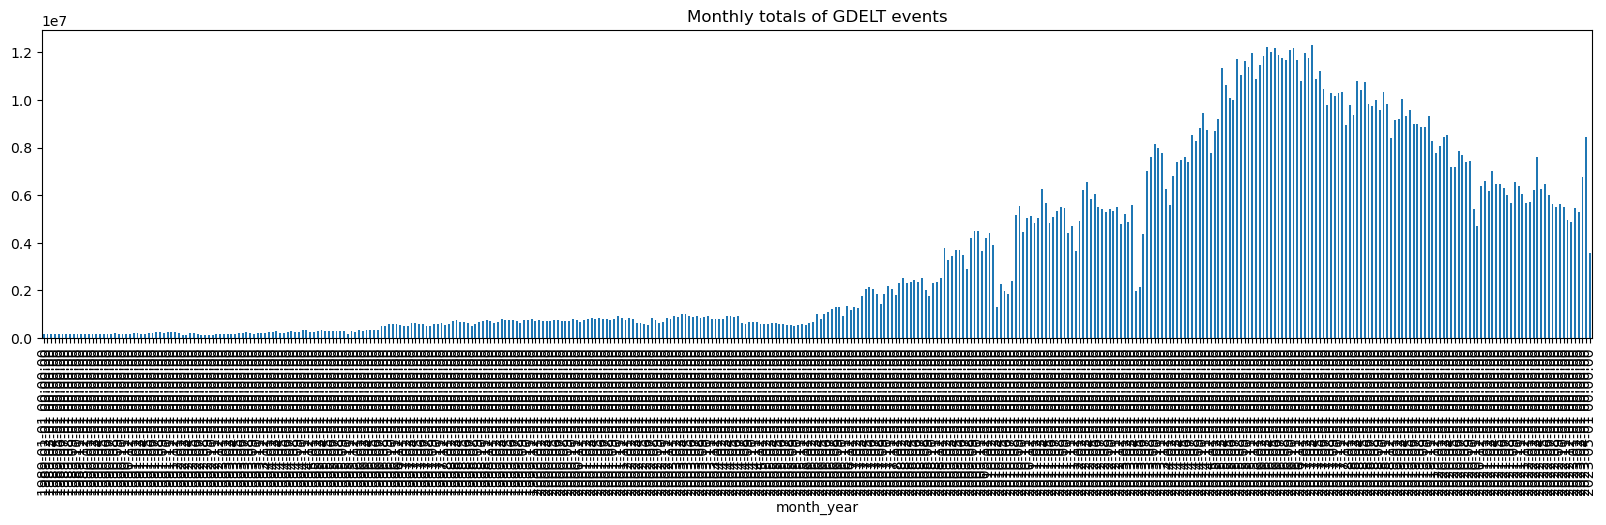

In [448]:
# normalise the events (dividing by the yearly totals)

# plot yearly totals
monthly_totals = df_feat.groupby('month_year')['total_events'].sum()
monthly_totals.plot.bar(figsize=(20, 4), title='Monthly totals of GDELT events')

# normalise the events (dividing by the yearly totals)
df_feat['norm_total_events'] = df_feat.groupby('month_year')['total_events'].transform(lambda x: x / monthly_totals[x.name])

df_feat.columns

#### Generate event_share stocks

In [417]:
def stock_simple(x: pd.Series, decay: float = 0.8):
    # xs is a stock of x inflow with a decay of 0.8
    # nans = x.isnull()
    x = list(x.fillna(0))
    xs = [] 
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            xs.append(x[n] + decay * xs[n-1])
    #list(np.where(nans, np.nan, xs))
    return xs

def stock_weighted(x: pd.Series, w: pd.Series, decay:float = 0.8):
    # xs is a stock of x inflow, weighted by w, with a decay of 0.8
    x = list(x.fillna(0))
    ws = stock_simple(w) # below this is the number of tokens for that country-month, which the stock_simple function turns into a discounted series
    w = list(w.fillna(0))
    xs = []
    
    for n in range(len(x)):
        if n == 0: 
            xs.append(x[n]) # stock starts in initial value
        else:
            num = w[n]*x[n] + decay * ws[n-1] * xs[n-1]
            
            # word stock for topic = tokens * topic share + decay * past word stock for topic
            # past word stock for topic = total words stock * topic stock share
            
            if ws[n]>0:
                xs.append(num/ws[n])
            else:
                xs.append(num)
    return xs
    

In [461]:
#event share stocks
decay = 0.8

# generates missing values for some months, starting Decemeber 2018 (when using Jan 2018 as start date)
# lcols = (df_feat.groupby(unit_of_analyis)
#         .apply(lambda x: stock_weighted(x['event_share_'+str(t)], x['norm_total_events'], decay=decay))
#         .explode().reset_index(drop=True)
#         .rename('event_share_' + str(t) +'_stock')
#         for t in range(1,21))
# df_feat = df_feat.join(pd.DataFrame(lcols).transpose())

lcols_novs = (df_feat.groupby(unit_of_analyis)
        .apply(lambda x: stock_simple(x[f'event_share_{t}'], decay=decay))
        .explode().reset_index(drop=True)
        .rename(f'event_share_{t}_stock')
        for t in range(1,21))
df_feat = df_feat.join(pd.DataFrame(lcols_novs).transpose())

#### Generate deaths per capita, binary conflict variable and demonstrate target generators

In [462]:
deaths_cutoff = 20

# generate deaths per capita
df_feat['deaths_pc'] = df_feat['deaths'] /  df_feat['wb_pop'] *1000000

# generate conflict variable
df_feat['conflict'] = (df_feat['deaths_pc'] >= deaths_cutoff).astype(int)

In [463]:
unit_of_analyis = 'isocode'

def make_target(df: pd.DataFrame, shifter: int, target: str): # t is the number of periods for the shift

    # loop through each period and generate the shift variables
    for i in range(1, shifter+1):
        col_name = f'{target}{i}' # name doesn't matter, just interimset str(target) + f'{i}' # 

        df[col_name] = df.groupby(unit_of_analyis)[str(target)].shift(-i)

    # take the maximum for t periods forward and create the new variable
    df['target_clsf_f{}'.format(shifter)] = df[[f'{target}{i}' for i in range(1, shifter+1)]].max(axis=1, skipna=False)

    # drop the shift variables
    df = df.drop(columns=[f'{target}{i}' for i in range(1, shifter+1)])
    
    return(df)

In [514]:
shifter = 3
target_clsf = 'conflict'
target_regr = 'deaths_pc'

df_exmpl = df_feat.copy()

# generate binary classification  target
df_exmpl = make_target(df_exmpl, shifter, target_clsf)

# generate regression target
df_exmpl[f'target_regr_f{shifter}'] = df_exmpl.groupby(unit_of_analyis)[target_regr].shift(-shifter)

# check it worked
df_exmpl.loc[df_exmpl['isocode'] == 'BFA', ['Country Name','year', 'deaths', 'wb_pop', 'deaths_pc', 'conflict', f'target_clsf_f{shifter}', f'target_regr_f{shifter}']][-8:]

,Country Name,year,deaths,wb_pop,deaths_pc,conflict,target_clsf_f3,target_regr_f3
90764,Burkina Faso,2022,105.0,22100683.0,4.750984,0,0.0,0.000000
91001,Burkina Faso,2022,203.0,22100683.0,9.185236,0,1.0,21.492548
91238,Burkina Faso,2022,195.0,22100683.0,8.823257,0,1.0,25.338583
91475,Burkina Faso,2023,0.0,22100683.0,0.000000,0,1.0,0.000000
91710,Burkina Faso,2023,475.0,22100683.0,21.492548,1,1.0,0.000000
91947,Burkina Faso,2023,560.0,22100683.0,25.338583,1,NaN,NaN
92184,Burkina Faso,2023,0.0,22100683.0,0.000000,0,NaN,NaN
92421,Burkina Faso,2023,0.0,22100683.0,0.000000,0,NaN,NaN


#### Generate historical variables of conflict

In [465]:
#adding columns for past deaths (rolling sum) - Hannes for some reason used the absolute number of deaths rather than the deaths per capita

lcols = (df_feat.groupby(unit_of_analyis)['deaths_pc'] # for each country
         .transform(lambda x: x.rolling(y, min_periods=1).sum()) # rolling sum of best
         .rename('past' + str(y-1)) 
         for y in [7, 13, 61, 121]) ##for y in [2, 3, 7, 12]) when I worked on annual level

df_feat = df_feat.join(pd.DataFrame(lcols).transpose())


In [466]:
def count_peace(x):
    # number of periods in peace
    x = list(x) 
    y = []
    for n in range(0, len(x)):
        if (x[n] == 0) & (n == 0):
            y.append(1) # if it starts in peace
        elif x[n] == 1:
            y.append(0) # reset to 0 if conflict
        else:
            y.append(y[n-1]+1) # add 1 if peace
    return y

In [467]:
# add columns that count the months since the last time a given type of conflict was present in that country
cols = ['conflict'] # could have several conlfict cut-offs (e.g. Hannes has: 'anyviolence', 'armedconf', 'civilwar')
names = [x+'_since' for x in cols] # sincelast variables are called anviolence_dp etc.
df_feat[names] = (df_feat.groupby('isocode')[cols].transform(count_peace))

## Model
- Prepare slice function
- Set parameters for Random Forest classifier and regressor
- Run the biog loop: once for classifier, once for regressor

In [468]:
df = df_feat.copy()
df.columns

Index(['MonthYear', 'isocode', 'month', 'year', 'country', 'deaths',
       'state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths',
       'month_year', 'Country Name', 'wb_pop', 'total_events', 'event_share_1',
       'event_share_2', 'event_share_3', 'event_share_4', 'event_share_5',
       'event_share_6', 'event_share_7', 'event_share_8', 'event_share_9',
       'event_share_10', 'event_share_11', 'event_share_12', 'event_share_13',
       'event_share_14', 'event_share_15', 'event_share_16', 'event_share_17',
       'event_share_18', 'event_share_19', 'event_share_20',
       'norm_total_events', 'deaths_pc', 'conflict', 'event_share_1_stock',
       'event_share_2_stock', 'event_share_3_stock', 'event_share_4_stock',
       'event_share_5_stock', 'event_share_6_stock', 'event_share_7_stock',
       'event_share_8_stock', 'event_share_9_stock', 'event_share_10_stock',
       'event_share_11_stock', 'event_share_12_stock', 'event_share_13_stock',
       'event_shar

### Prepare slice

In [479]:
# Lists of variables to keep for each model: including the stock for each set of text data is optional

# should we distinguid between his_vars_clsf and his_vars_regr ?
historical_vars = ['deaths_pc', 'conflict', 'past6', 'past12', 'past60', 'past120','conflict_since']


text_gdelt_shares = ['norm_total_events',
                   'event_share_1', 'event_share_2', 'event_share_3', 'event_share_4', 'event_share_5',
                   'event_share_6','event_share_7', 'event_share_8', 'event_share_9', 'event_share_10',
                   'event_share_11', 'event_share_12', 'event_share_13', 'event_share_14','event_share_15',
                   'event_share_16', 'event_share_17', 'event_share_18','event_share_19', 'event_share_20'] # before normalisation: total_events

text_gdelt_stocks = ['event_share_1_stock', 'event_share_2_stock',
       'event_share_3_stock', 'event_share_4_stock', 'event_share_5_stock',
       'event_share_6_stock', 'event_share_7_stock', 'event_share_8_stock',
       'event_share_9_stock', 'event_share_10_stock', 'event_share_11_stock',
       'event_share_12_stock', 'event_share_13_stock', 'event_share_14_stock',
       'event_share_15_stock', 'event_share_16_stock', 'event_share_17_stock',
       'event_share_18_stock', 'event_share_19_stock', 'event_share_20_stock']

text_gdelt_vars = text_gdelt_shares #+ text_gdelt_stocks

other_vars = ['deaths','state_deaths', 'nonstate_deaths', 'onesided_deaths', 'civilian_deaths'] #['IncomeGroup', 'Region']

time_var = ['month_year']
id_var = ['isocode']

In [480]:
# Decide within prepare slice which columns to include for each model and adjust these lengths accordingly
# They allow us to keep track of feature importance, an addition we made to Hannes's original code
combomodel_var_len = len(historical_vars + text_gdelt_vars) 
historymodel_var_len = len(historical_vars) 
textmodel_varl_len = len(text_gdelt_vars)

In [481]:
def prepare_slice(df, date, target, forward, binary = True):
    df = df.copy()

    # Establish past: keep only what is before the current year 
    data = df[df.month_year < date]
    print('pre drop data: ', len(data))

    # Establish future: keep only currrent time period, which is to be predicted 
    future = df[df.month_year == date]	
    print('pre drop future: ', len(future))

    # generate the shifted target
    # define the dependent variables as generated by the make_target function (for binary) or pure shifter (for regression)
    if binary:
        data_target = make_target(df=data, shifter=forward, target=target)
        
        # When this is used in the loop later, we will predice forward 1 and 2 business days
        deps=['target_clsf_f{}'.format(forward)] 

    else:
        data_target = data.groupby(unit_of_analyis)[target].shift(-forward)
        deps=['target_regr_f{}'.format(forward)] 


    # choose which data to keep for which model
    # X-vars
    combomodel = historical_vars + text_gdelt_vars 
    historymodel = historical_vars
    textmodel = text_gdelt_vars 

    # full columns with X-vars, y-var and id-vars
    combomodel_all = combomodel + id_var + time_var + deps
    historymodel_all = historymodel + id_var + time_var + deps
    textmodel_all = textmodel + id_var + time_var + deps

    # Model 1: Full or augmented/ combined model
    df_all = data[combomodel_all].dropna()
    print('post drop model: ', len(df_all)) # the others have the same length
    y_all = df_all[deps].values.ravel() # all models have the same target

    # Model 2: History model 
    df_hs = data[historymodel_all].dropna()

    # Model 3: Pure text-based (novelty) model
    df_tx = data[textmodel_all].dropna()
    
    # Training data: X-vars - no Ticker or Date, NaNs already dropped
    X_all = df_all[combomodel]
    X_hs = df_hs[historymodel]
    X_tx = df_tx[textmodel]

    # Remove dependent variable from column lists - still includes Date and Ticker
    combomodel_all.remove(deps[0])
    historymodel_all.remove(deps[0])
    textmodel_all.remove(deps[0])

    # Use these columns for the future (out-of-sample) data for the models
    df_fut_all = future[combomodel_all].dropna()
    df_fut_hs = future[historymodel_all].dropna()
    df_fut_tx = future[textmodel_all].dropna()

    # Data (X-vars) at time T for producing fitted values - no Date or Ticker
    X_fut_all = df_fut_all[combomodel]
    X_fut_hs = df_fut_hs[historymodel]
    X_fut_tx = df_fut_tx[textmodel]

    return X_all, X_hs, X_tx, y_all, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx


In [482]:
# Exemplification of prepare slice:
data = df.copy()
start_date = dt.datetime(2018, 1, 1) 

# number of business days ahead to predict (will shorten target frame by forward * number of firms (5))
forward = 2
target_clsf = 'conflict'
binary_target = True

#apply prepare slice
X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(data, start_date, target, forward, binary_target)

# Explaning output
print(y.shape)

print('___')
print(df_all.shape)   # all X-vars, other and target
print(df_fut_all.shape) # all X-vars and other, but NO dep - only 1 day

print(X_all.shape)    # no Ticker/date/target and final row removed for all 
print(X_fut_all.shape)  # no Ticker/date/target  - only 1 day

print('___')
print(df_hs.shape)
print(df_fut_hs.shape)

print(X_hs.shape)   
print(X_fut_hs.shape)

print('___')
print(df_tx.shape)
print(df_fut_tx.shape)

print(X_tx.shape)   
print(X_fut_tx.shape)


pre drop data:  67200
pre drop future:  195
post drop model:  66798
(66798,)
___
(66798, 31)
(195, 30)
(66798, 28)
(195, 28)
___
(66798, 10)
(195, 9)
(66798, 7)
(195, 7)
___
(66799, 24)
(195, 23)
(66799, 21)
(195, 21)


### Set parameters

In [473]:
def setparams_regr(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):     
    '''function to set the parameters of the RF model'''
    
    regressor=RandomForestRegressor(n_estimators=treenumber,  max_depth =depthnumber,
                               min_samples_split =min_samples_number, min_samples_leaf =  min_samples_leaf_number,
                             n_jobs=8) 
    return regressor

def setparams_clsf(treenumber, depthnumber, min_samples_number, min_samples_leaf_number):  
    '''function to set the parameters of the RF model'''
    
    classifier=RandomForestClassifier(n_estimators=treenumber,  max_depth =depthnumber, 
                               min_samples_split =min_samples_number, min_samples_leaf =  min_samples_leaf_number
                             ,n_jobs=8, class_weight = 'balanced') #criterion='gini'
    return classifier

In [474]:
# set randomforest variables 

# fixed parameters
trees=700
min_samples_splits=2
min_samples_leafs = 100

# varying parameters
fwd = [1,2] # we predict 1 and 2 months ahead
dpths = [8] # we could use more depths, but this would increase the time in takes to run this code


### Run big loop

Once for classifier, once for regressor.

In [475]:
# specify targets
target_regr = 'deaths_pc'
target_clsf = 'conflict'

# decide on period to predict for
start_month_year = datetime(2018, 1, 1)
end_month_year = datetime(2021,12,1)#(2018, 12, 1)

In [476]:
def generate_monthly_dates(start_month_year, end_month_year):
    current_date = start_month_year.replace(day=1)
    dates = []

    while current_date <= end_month_year:
        dates.append(current_date)
        current_date += relativedelta(months=1)
        
    return dates

# dates = generate_monthly_dates(start_month_year, end_month_year)
# for date in dates:
#      print(date.strftime('%Y-%m-%d'))

#### Run big look for Regressor

In [483]:
# Shorten the data frame 
prepped_data = df.copy()

drop_before = dt.datetime(2000, 1, 1) # instead of starting from 1989
prepped_data = prepped_data[prepped_data.month_year >= drop_before ]

print(target_regr)
prepped_data.shape

deaths_pc


(54747, 62)

In [484]:
pd.set_option('display.max_columns', 500)
prepped_data.isna().sum()

for column in prepped_data.columns:
    print(f"{column}: {prepped_data[column].isna().sum()}")

prepped_data.loc[prepped_data['event_share_1_stock'].isna()]

MonthYear: 0
isocode: 0
month: 0
year: 0
country: 45771
deaths: 0
state_deaths: 0
nonstate_deaths: 0
onesided_deaths: 0
civilian_deaths: 0
month_year: 0
Country Name: 0
wb_pop: 0
total_events: 0
event_share_1: 0
event_share_2: 0
event_share_3: 0
event_share_4: 0
event_share_5: 0
event_share_6: 0
event_share_7: 0
event_share_8: 0
event_share_9: 0
event_share_10: 0
event_share_11: 0
event_share_12: 0
event_share_13: 0
event_share_14: 0
event_share_15: 0
event_share_16: 0
event_share_17: 0
event_share_18: 0
event_share_19: 0
event_share_20: 0
norm_total_events: 0
deaths_pc: 0
conflict: 0
event_share_1_stock: 10511
event_share_2_stock: 10511
event_share_3_stock: 10511
event_share_4_stock: 10511
event_share_5_stock: 10511
event_share_6_stock: 10511
event_share_7_stock: 10511
event_share_8_stock: 10511
event_share_9_stock: 10511
event_share_10_stock: 10511
event_share_11_stock: 10511
event_share_12_stock: 10511
event_share_13_stock: 10511
event_share_14_stock: 10511
event_share_15_stock: 105

,MonthYear,isocode,month,year,country,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,total_events,event_share_1,event_share_2,event_share_3,event_share_4,event_share_5,event_share_6,event_share_7,event_share_8,event_share_9,event_share_10,event_share_11,event_share_12,event_share_13,event_share_14,event_share_15,event_share_16,event_share_17,event_share_18,event_share_19,event_share_20,norm_total_events,deaths_pc,conflict,event_share_1_stock,event_share_2_stock,event_share_3_stock,event_share_4_stock,event_share_5_stock,event_share_6_stock,event_share_7_stock,event_share_8_stock,event_share_9_stock,event_share_10_stock,event_share_11_stock,event_share_12_stock,event_share_13_stock,event_share_14_stock,event_share_15_stock,event_share_16_stock,event_share_17_stock,event_share_18_stock,event_share_19_stock,event_share_20_stock,past6,past12,past60,past120,conflict_since
79875,1970-01-01 00:00:00.000201812,BLR,12,2018,NaN,0.0,0.0,0.0,0.0,0.0,2018-12-01,Belarus,9438785.0,8968.0,12.711864,5.842997,10.838537,33.273863,11.262266,3.702052,1.761820,2.074041,0.780553,1.739518,4.527208,2.832293,0.735950,0.579839,0.423729,0.535236,4.103479,0.356824,1.917930,0.000000,0.001067,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,360
79876,1970-01-01 00:00:00.000201812,BLZ,12,2018,NaN,0.0,0.0,0.0,0.0,0.0,2018-12-01,Belize,382066.0,4262.0,14.453308,5.114969,4.927264,37.587987,8.446739,2.064758,3.237916,3.707180,2.252464,0.610042,2.674801,1.501642,0.469263,0.234632,0.046926,0.422337,2.956359,1.923979,7.367433,0.000000,0.000507,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,349
79877,1970-01-01 00:00:00.000201812,BMU,12,2018,NaN,0.0,0.0,0.0,0.0,0.0,2018-12-01,Bermuda,63918.0,3428.0,24.737456,9.159860,7.117853,25.087515,7.759627,2.392065,4.434072,2.217036,2.333722,0.991832,4.084014,1.633606,1.458576,0.233372,0.000000,0.525088,3.558926,0.291715,1.983664,0.000000,0.000408,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,360
79878,1970-01-01 00:00:00.000201812,BOL,12,2018,NaN,0.0,0.0,0.0,0.0,0.0,2018-12-01,Bolivia,11606905.0,2766.0,9.544469,5.422993,6.073753,31.453362,10.195228,4.989154,3.181490,4.844541,2.169197,1.301518,4.266088,3.253796,0.650759,1.735358,0.000000,0.506146,6.001446,0.795372,3.615329,0.000000,0.000329,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,360
79879,1970-01-01 00:00:00.000201812,BRA,12,2018,Brazil,30.0,0.0,30.0,0.0,1.0,2018-12-01,Brazil,210166592.0,35342.0,14.764303,5.857054,8.567710,25.193820,7.826382,3.418030,2.110803,4.170675,1.720333,1.663743,5.891008,2.280573,1.165752,0.628148,0.260314,0.775282,5.132703,1.561881,6.988852,0.022636,0.004204,0.142744,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.836638,11.410679,25.044506,26.792222,360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92632,1970-01-01 00:00:00.000202305,XKX,05,2023,NaN,0.0,0.0,0.0,0.0,0.0,2023-05-01,Kosovo,1786038.0,650.0,9.230769,7.692308,8.923077,30.769231,19.076923,0.307692,1.846154,1.230769,1.846154,5.230769,4.000000,1.846154,0.307692,0.923077,0.000000,1.230769,0.923077,1.230769,3.384615,0.000000,0.000183,0.000000,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,412
92633,1970-01-01 00:00:00.000202305,YEM,05,2023,NaN,0.0,0.0,0.0,0.0,0.0,2023-05-01,"Yemen, Rep.",32981641.0,3358.0,8.219178,4.645622,5.419893,40.619416,10.780226,1.131626,3.037522,5.539011,0.833830,1.250744,2.739726,0.833830,1.42

For target deaths_pc: checking forward 1 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41877
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  42072
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42267
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42462
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42657
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42852
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  43047
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43242
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43437
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futu

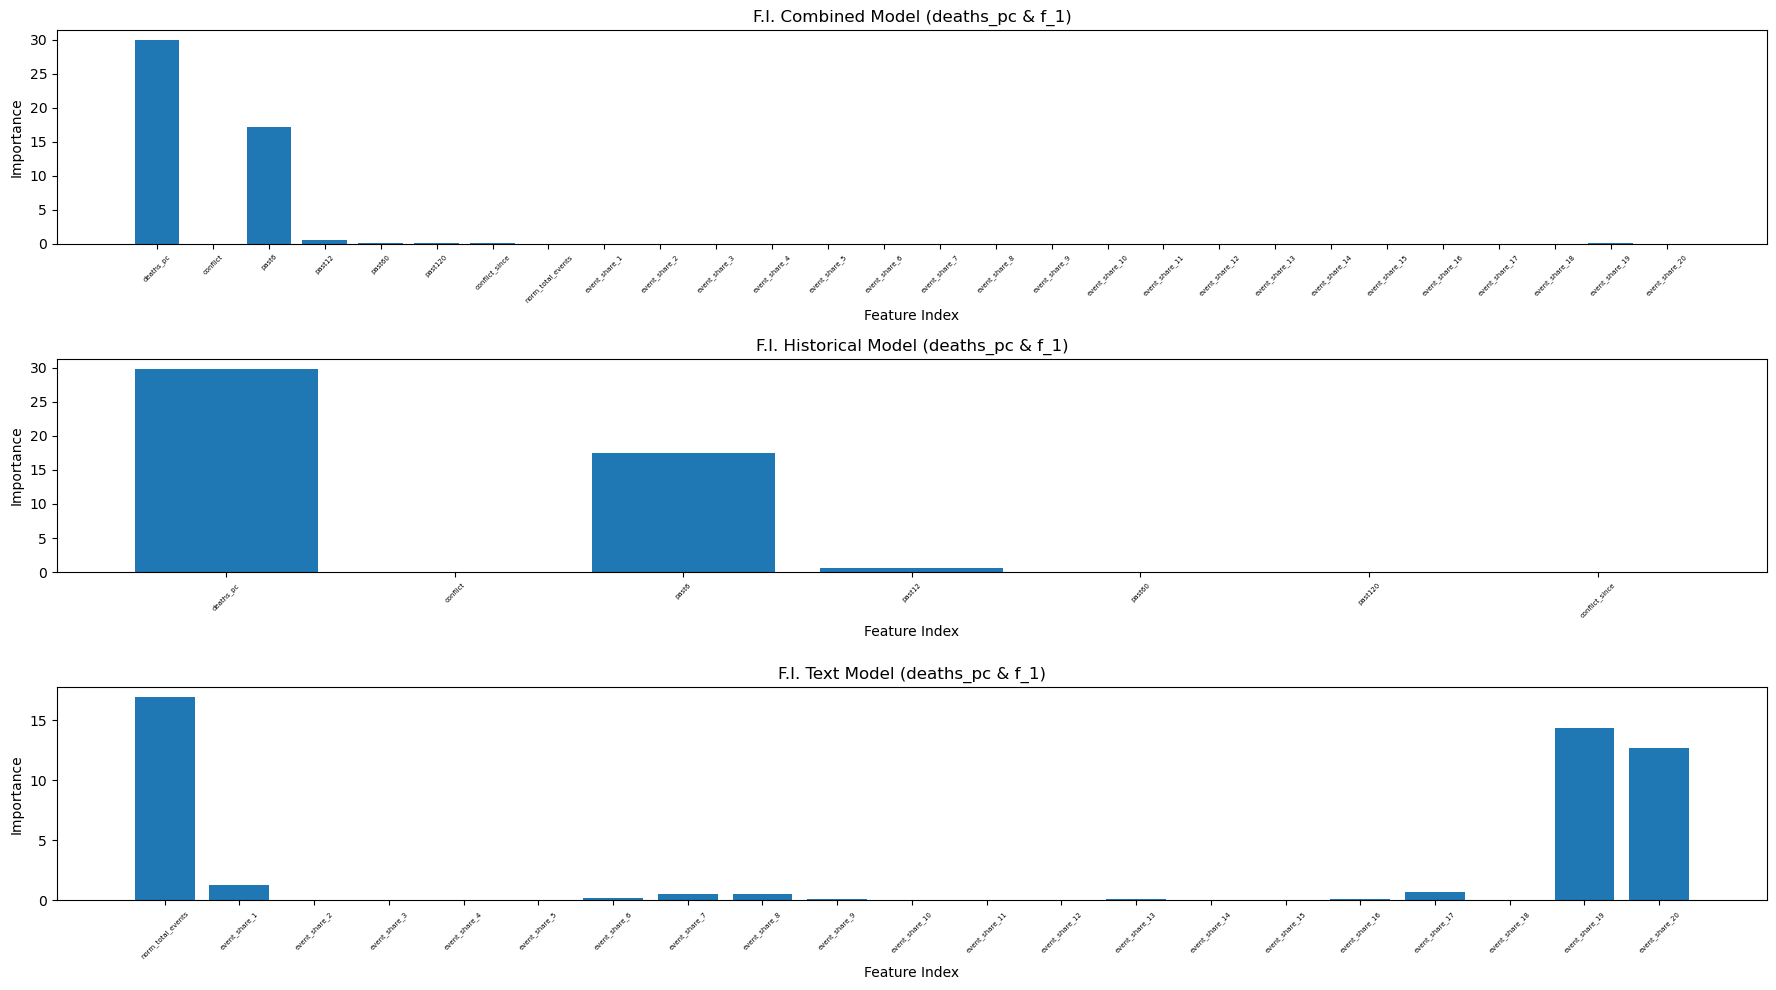

For target deaths_pc: checking forward 2 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41682
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  41877
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42072
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42267
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42462
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42657
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  42852
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43047
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43242
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futu

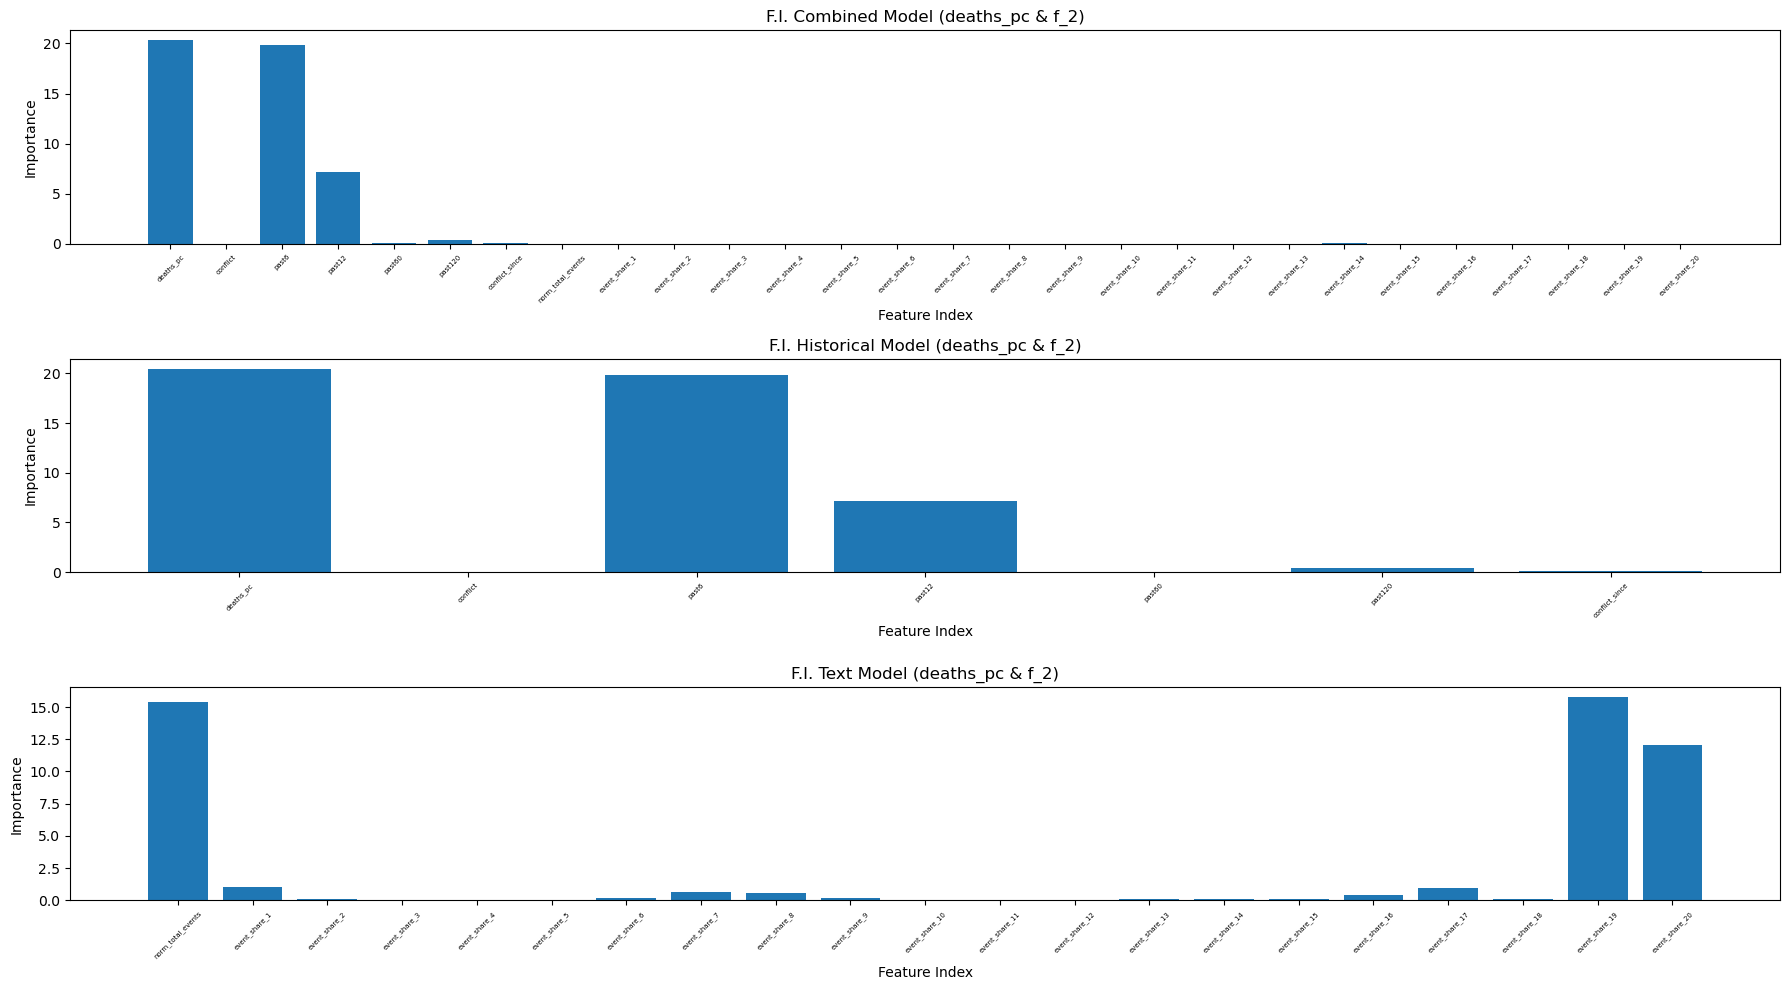

In [485]:
for dep in [target_regr]: # we only have one dependent variable: stock price changes

    for forward,depth in zip(fwd,dpths):

        #for dp in depths:
        for forward in fwd:

            fittedframe = pd.DataFrame(columns=id_var + time_var)

            print(f'For target {dep}: checking forward {forward} with depth {depth}')
            
            print('Setting parameters')
            RF_all = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)
            RF_hs = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)
            RF_tx = setparams_regr(trees, depth, min_samples_splits, min_samples_leafs)

            # to keep track of feature importances for each model (all, hs, tx)
            accumulated_importances_all = [0] * combomodel_var_len
            accumulated_importances_hs = [0] * historymodel_var_len
            accumulated_importances_tx = [0] * textmodel_varl_len

            
            # generates list of all working days between start and end date  
            #business_day_dates = generate_business_day_dates(startdate_id, end_date, [])

            # generate list of all months between start and end date
            future_months = generate_monthly_dates(start_month_year, end_month_year)
    
            for current_date in future_months:
                print('Month: ', current_date)
                
                # prepare slice for the current year and dep variable
                X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(prepped_data, current_date, dep, forward, binary = True)

                # fit the model to the relevant X and y data
                RF_all.fit(X_all, y) # .astype(int) - when using classifier
                RF_hs.fit(X_hs, y)
                RF_tx.fit(X_tx, y)

                # add feature importances to the accumulated list
                importances_all = RF_all.feature_importances_
                importances_hs = RF_hs.feature_importances_
                importances_tx = RF_tx.feature_importances_

                accumulated_importances_all += importances_all
                accumulated_importances_hs += importances_hs
                accumulated_importances_tx += importances_tx

                # predict the future data for each model
                results_all = RF_all.predict(X_fut_all) # predict_proba(X_fut_all) - when using classifier
                results_hs = RF_hs.predict(X_fut_hs)
                results_tx = RF_tx.predict(X_fut_tx)

                # prepare data frames and add the prediction results for each model 
                pred_fut_all = df_fut_all[id_var + time_var]
                pred_fut_hs = df_fut_hs[id_var + time_var]
                pred_fut_tx = df_fut_tx[id_var + time_var]

                pred_fut_all[f'pred_{dep}_f{forward}_all'] = results_all[:] # if predict_proba [:,1]
                pred_fut_hs[f'pred_{dep}_f{forward}_hs'] = results_hs[:]
                pred_fut_tx[f'pred_{dep}_f{forward}_tx'] = results_tx[:]

                # comnbine the results
                pred_future=pd.merge(pred_fut_all,pred_fut_hs,on=id_var+time_var,how='outer')
                pred_future=pd.merge(pred_future,pred_fut_tx,on=id_var+time_var,how='outer')
                
                # add each year's results to the fittedframe:
                fittedframe=pd.concat([fittedframe,pred_future])
            
            # save predictions for three models to csv before moving to next target (dep) and shifter (forward)
            fittedframe.to_csv(f"predictions_regr_f{forward}_d{depth}_{dep}.csv")
            print('Saved predictions for forward ', forward, ' and depth ', depth, ' and target ', dep, 'to directory', os.getcwd())

            # plot feature importances for each model
            fig, axs = plt.subplots(3, 1, figsize=(18, 10))
        
            feature_labels_all = X_all.columns
            feature_labels_hs = X_hs.columns
            feature_labels_tx = X_tx.columns

            axs[0].bar(range(combomodel_var_len), accumulated_importances_all)
            axs[0].set_xlabel('Feature Index')
            axs[0].set_ylabel('Importance')
            axs[0].set_title(f'F.I. Combined Model ({dep} & f_{forward})')
            axs[0].set_xticks(range(combomodel_var_len), feature_labels_all,rotation=45, fontsize=5)

            axs[1].bar(range(historymodel_var_len), accumulated_importances_hs)
            axs[1].set_xlabel('Feature Index')
            axs[1].set_ylabel('Importance')
            axs[1].set_title(f'F.I. Historical Model ({dep} & f_{forward})')
            axs[1].set_xticks(range(historymodel_var_len), feature_labels_hs, rotation=45, fontsize=5)

            axs[2].bar(range(textmodel_varl_len), accumulated_importances_tx)
            axs[2].set_xlabel('Feature Index')
            axs[2].set_ylabel('Importance')
            axs[2].set_title(f'F.I. Text Model ({dep} & f_{forward})')
            axs[2].set_xticks(range(textmodel_varl_len), feature_labels_tx, rotation=45, fontsize=5)
            
            plt.tight_layout()
            plt.show()

#### Run big loop for Classifier

In [496]:
# Shorten the data frame 
prepped_data = df.copy()

drop_before = dt.datetime(2000, 1, 1) # instead of starting from 1989
prepped_data = prepped_data[prepped_data.month_year >= drop_before ]

print(target_clsf)
prepped_data.shape

conflict


(54747, 62)

In [501]:
print(start_month_year, end_month_year)
fwd = [1, 2]
print(fwd, dpths)
print(target_clsf)



2018-01-01 00:00:00 2021-12-01 00:00:00
[1, 2] [8]
conflict


For target conflict: checking forward 1 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41877
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  42072
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42267
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42462
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42657
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42852
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  43047
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43242
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43437
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futur

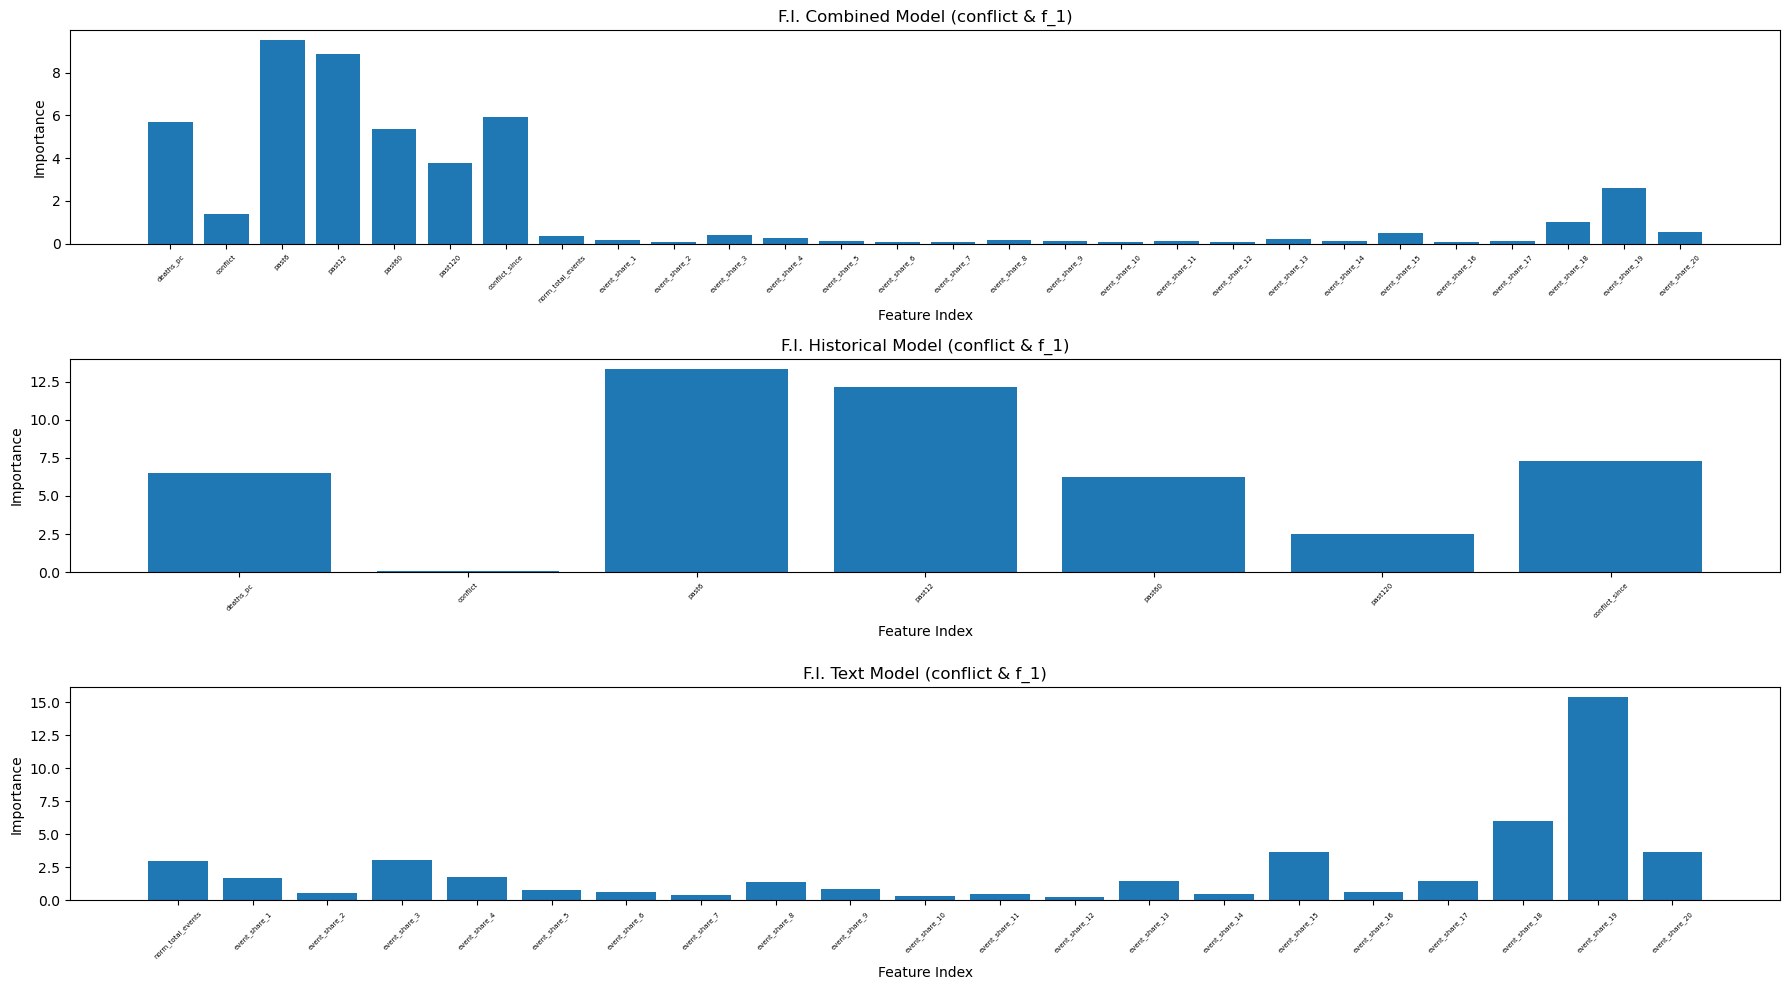

For target conflict: checking forward 2 with depth 8
Setting parameters
Month:  2018-01-01 00:00:00
pre drop data:  42072
pre drop future:  195
post drop model:  41682
Month:  2018-02-01 00:00:00
pre drop data:  42267
pre drop future:  195
post drop model:  41877
Month:  2018-03-01 00:00:00
pre drop data:  42462
pre drop future:  195
post drop model:  42072
Month:  2018-04-01 00:00:00
pre drop data:  42657
pre drop future:  195
post drop model:  42267
Month:  2018-05-01 00:00:00
pre drop data:  42852
pre drop future:  195
post drop model:  42462
Month:  2018-06-01 00:00:00
pre drop data:  43047
pre drop future:  195
post drop model:  42657
Month:  2018-07-01 00:00:00
pre drop data:  43242
pre drop future:  195
post drop model:  42852
Month:  2018-08-01 00:00:00
pre drop data:  43437
pre drop future:  195
post drop model:  43047
Month:  2018-09-01 00:00:00
pre drop data:  43632
pre drop future:  195
post drop model:  43242
Month:  2018-10-01 00:00:00
pre drop data:  43827
pre drop futur

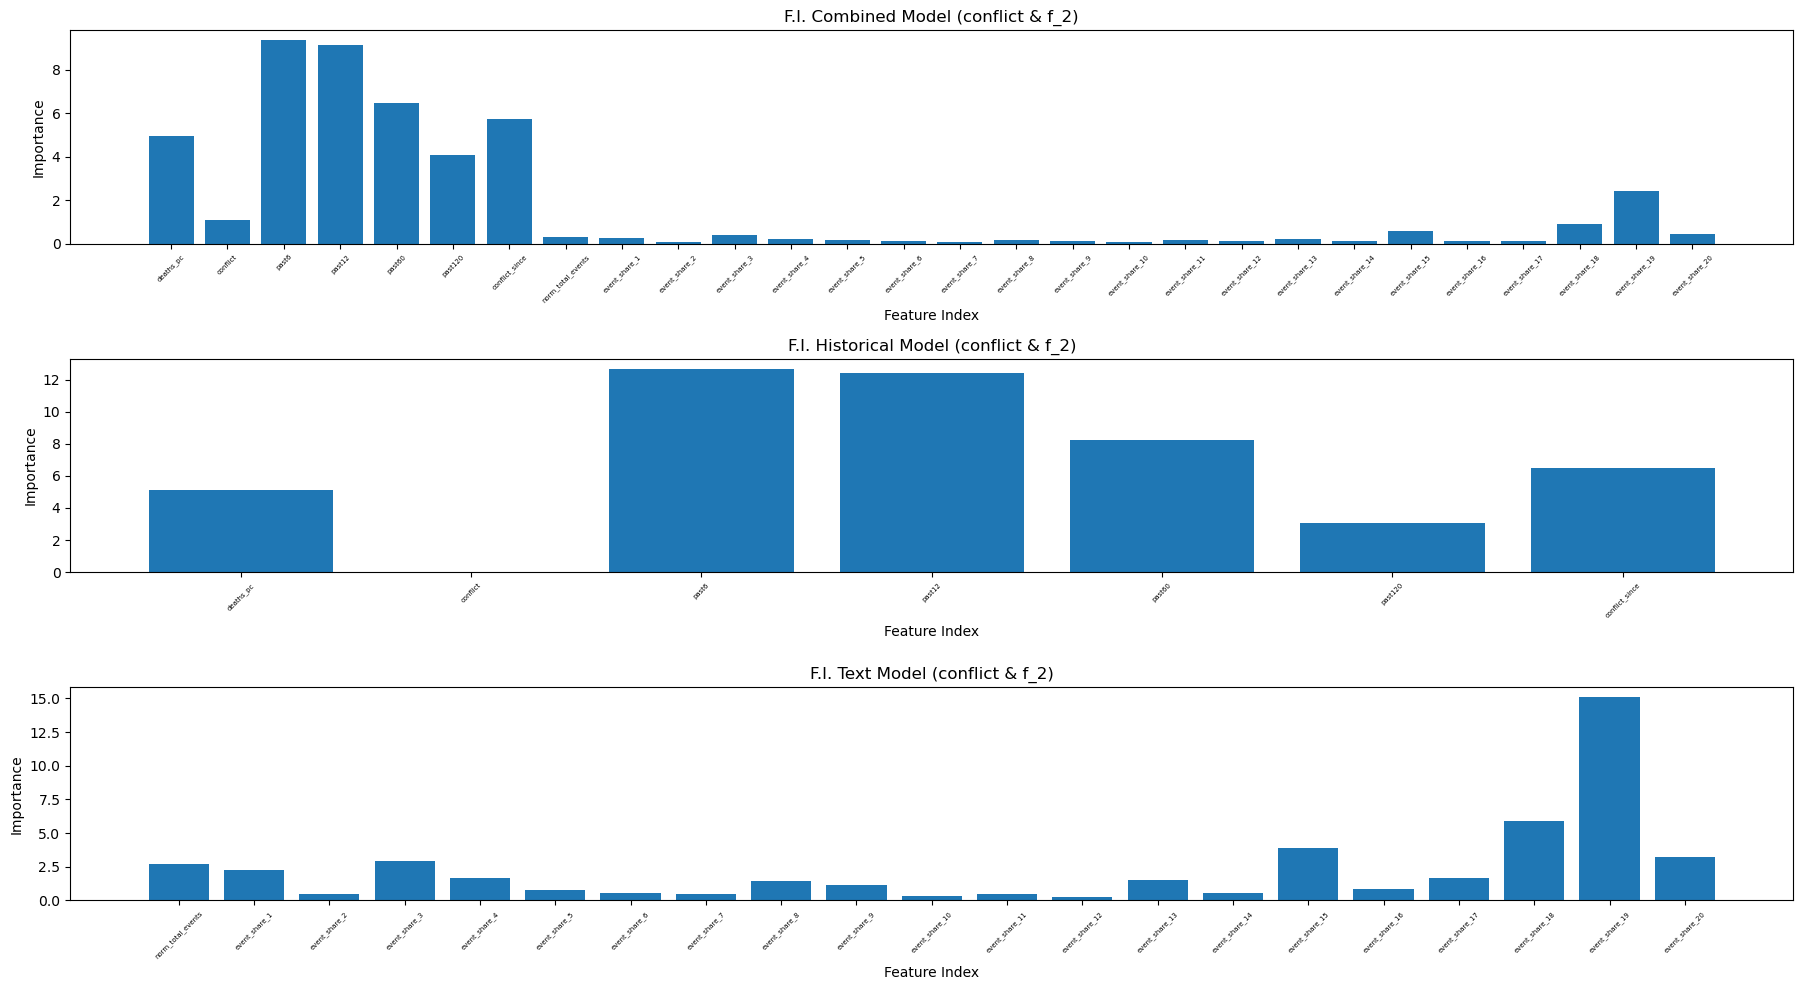

In [502]:
for dep in [target_clsf]: # we only have one dependent variable: stock price changes

    for forward,depth in zip(fwd,dpths):

        #for dp in depths:
        for forward in fwd:

            fittedframe = pd.DataFrame(columns=id_var + time_var)

            print(f'For target {dep}: checking forward {forward} with depth {depth}')
            
            print('Setting parameters')
            clf_all = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)
            clf_hs = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)
            clf_tx = setparams_clsf(trees, depth, min_samples_splits, min_samples_leafs)

            # to keep track of feature importances for each model (all, hs, tx)
            accumulated_importances_all = [0] * combomodel_var_len
            accumulated_importances_hs = [0] * historymodel_var_len
            accumulated_importances_tx = [0] * textmodel_varl_len

            
            # generates list of all working days between start and end date  
            #business_day_dates = generate_business_day_dates(startdate_id, end_date, [])

            # generate list of all months between start and end date
            future_months = generate_monthly_dates(start_month_year, end_month_year)
    
            for current_date in future_months:
                print('Month: ', current_date)
                
                # prepare slice for the current year and dep variable
                X_all, X_hs, X_tx, y, X_fut_all, X_fut_hs, X_fut_tx, df_all, df_hs, df_tx, df_fut_all, df_fut_hs, df_fut_tx  = prepare_slice(prepped_data, current_date, dep, forward, binary = True)

                # fit the model to the relevant X and y data
                clf_all.fit(X_all, y) # .astype(int) - when using classifier
                clf_hs.fit(X_hs, y)
                clf_tx.fit(X_tx, y)

                # add feature importances to the accumulated list
                importances_all = clf_all.feature_importances_
                importances_hs = clf_hs.feature_importances_
                importances_tx = clf_tx.feature_importances_

                accumulated_importances_all += importances_all
                accumulated_importances_hs += importances_hs
                accumulated_importances_tx += importances_tx

                # predict the future data for each model
                results_all = clf_all.predict(X_fut_all) # predict_proba(X_fut_all) - when using classifier
                results_hs = clf_hs.predict(X_fut_hs)
                results_tx = clf_tx.predict(X_fut_tx)

                # prepare data frames and add the prediction results for each model 
                pred_fut_all = df_fut_all[id_var + time_var]
                pred_fut_hs = df_fut_hs[id_var + time_var]
                pred_fut_tx = df_fut_tx[id_var + time_var]

                pred_fut_all[f'pred_{dep}_f{forward}_all'] = results_all[:] # if predict_proba [:,1]
                pred_fut_hs[f'pred_{dep}_f{forward}_hs'] = results_hs[:]
                pred_fut_tx[f'pred_{dep}_f{forward}_tx'] = results_tx[:]

                # comnbine the results
                pred_future=pd.merge(pred_fut_all,pred_fut_hs,on=id_var+time_var,how='outer')
                pred_future=pd.merge(pred_future,pred_fut_tx,on=id_var+time_var,how='outer')
                
                # add each year's results to the fittedframe:
                fittedframe=pd.concat([fittedframe,pred_future])
            
            # save predictions for three models to csv before moving to next target (dep) and shifter (forward)
            fittedframe.to_csv(f"predictions_clsf_f{forward}_d{depth}_{dep}.csv")
            print('Saved predictions for forward ', forward, ' and depth ', depth, ' and target ', dep, 'to directory', os.getcwd())

            # plot feature importances for each model
            fig, axs = plt.subplots(3, 1, figsize=(18, 10))
        
            feature_labels_all = X_all.columns
            feature_labels_hs = X_hs.columns
            feature_labels_tx = X_tx.columns

            axs[0].bar(range(combomodel_var_len), accumulated_importances_all)
            axs[0].set_xlabel('Feature Index')
            axs[0].set_ylabel('Importance')
            axs[0].set_title(f'F.I. Combined Model ({dep} & f_{forward})')
            axs[0].set_xticks(range(combomodel_var_len), feature_labels_all,rotation=45, fontsize=5)

            axs[1].bar(range(historymodel_var_len), accumulated_importances_hs)
            axs[1].set_xlabel('Feature Index')
            axs[1].set_ylabel('Importance')
            axs[1].set_title(f'F.I. Historical Model ({dep} & f_{forward})')
            axs[1].set_xticks(range(historymodel_var_len), feature_labels_hs, rotation=45, fontsize=5)

            axs[2].bar(range(textmodel_varl_len), accumulated_importances_tx)
            axs[2].set_xlabel('Feature Index')
            axs[2].set_ylabel('Importance')
            axs[2].set_title(f'F.I. Text Model ({dep} & f_{forward})')
            axs[2].set_xticks(range(textmodel_varl_len), feature_labels_tx, rotation=45, fontsize=5)
            
            plt.tight_layout()
            plt.show()


## Metrics
- Metrics for classifier (ROC & Precision-Recall)
- Metrics for regressor (RMSE)

### Metrics for regressor

In [517]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str):
    
    target_col = f'target_regr_f{fwd}'
    pred_col = f'pred_{target}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'date_str', target_col, pred_col]] 
    df['month_year'] = pd.to_datetime(df['date_str'])
    df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

In [518]:
# load all predictions and combined them into one dataframe
#pred_f1 = pd.read_csv(os.path.abspath(path + '/preds/2018only_regr_since2000/predictions_f1_d8_conflict.csv'))
#pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_f1_d8_deaths_pc.csv'))

pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_regr_f1_d8_deaths_pc.csv'))
pred_f1.drop('Unnamed: 0', axis=1, inplace=True)

pred_f2 = pd.read_csv(os.path.abspath(path + '/predictions_regr_f2_d8_deaths_pc.csv'))
pred_f2.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1.shape, pred_f2.shape)

pred_vals_regr = pd.merge(pred_f1, pred_f2, on=[unit_of_analyis, 'month_year'], how='outer')
#pred_vals_regr = pred_f1


(9360, 5) (9360, 5)


In [519]:
# get original values and generate relevant target columns (for classification do this with make_target function)

og_vals = prepped_data.copy()
cols_to_keep = ['month_year', unit_of_analyis, target_regr] 
og_vals = og_vals[cols_to_keep]

fwds = [1,2]
for fwd in fwds:
        #og_vals = make_target(og_vals, fwd, target_clsf)
        og_vals[f'target_regr_f{fwd}'] = og_vals.groupby(unit_of_analyis)[target_regr].shift(-fwd)


# drop training data values
og_vals = og_vals[og_vals['month_year'] >= start_month_year]

# drop months not inlcuded in prediction range
og_vals = og_vals[og_vals['month_year'] <= end_month_year]

print(og_vals.shape, pred_vals_regr.shape)


(9360, 5) (9360, 8)


In [520]:

# Because it didn't like merging on the date column, I made a string version of Date
pred_vals_regr['date_str'] = pred_vals_regr['month_year'].astype(str)
og_vals['date_str'] = og_vals['month_year'].astype(str)

og_vals.drop('month_year', axis=1, inplace=True)
pred_vals_regr.drop('month_year', axis=1, inplace=True)

pred_all_regr = pd.merge(og_vals, pred_vals_regr, on=['date_str', unit_of_analyis], how='outer')
pred_all_regr

,isocode,deaths_pc,target_regr_f1,target_regr_f2,date_str,pred_deaths_pc_f1_all,pred_deaths_pc_f1_hs,pred_deaths_pc_f1_tx,pred_deaths_pc_f2_all,pred_deaths_pc_f2_hs,pred_deaths_pc_f2_tx
0,AFG,48.382546,40.641338,39.332965,2018-01-01,109.321300,108.985486,16.593090,123.792712,122.385439,21.250712
1,AGO,0.000000,0.000000,0.031976,2018-01-01,0.103181,0.112367,0.021909,0.182961,0.194637,0.045709
2,ALB,0.000000,0.000000,0.000000,2018-01-01,0.007029,0.005465,0.137583,0.011794,0.009132,0.187738
3,ARE,0.000000,0.000000,0.000000,2018-01-01,0.006755,0.005668,0.024124,0.012681,0.009921,0.044779
4,ARG,0.000000,0.000000,0.000000,2018-01-01,0.007290,0.005465,0.067238,0.011734,0.009132,0.105410
...,...,...,...,...,...,...,...,...,...,...,...
9355,XKX,0.000000,0.000000,0.000000,2021-12-01,0.027243,0.004954,0.088201,0.016148,0.007450,0.186851
9356,YEM,38.870110,5.215023,14.917390,2021-12-01,61.460506,66.780384,7.834759,91.352385,87.476550,17.416105
9357,ZAF,0.000000,0.016837,0.016837,2021-12-01,0.113746,0.213627,0.210457,0.191247,0.424515,0.310777
9358,ZMB,0.000000,0.000000,0.000000,2021-12-01,0.006046,0.004954,0.203397,0.010480,0.007450,0.241467


In [521]:
target = target_regr
fwds = [1,2]
models = ['all', 'hs', 'tx']

start_date = start_date ##start_date = dt.datetime(2018, 1, 2)

errors = {}

for fwd in fwds:
    for model in models:
            
            y_trues, y_preds = get_tar_pred(pred_all_regr, fwd, model, start_date, target_regr)
        
            errors[f'{model}_{fwd}'] = mean_squared_error(y_trues, y_preds)

print('All Root Mean Squared Errors:')
print(pd.Series(errors)) #.sort_values()

All Root Mean Squared Errors:
all_1    34.536005
hs_1     34.858765
tx_1     42.512232
all_2    64.611120
hs_2     64.630842
tx_2     55.015521
dtype: float64


### Metrics for classifier

In [503]:
# Allows us to obtain the predictions for a given target and original shifted data

def get_tar_pred(df: pd.DataFrame() , fwd: int, model: str, start_time: dt, target: str):
    
    target_col = f'target_clsf_f{fwd}'
    pred_col = f'pred_{target}_f{fwd}_{model}'

    df = df[[unit_of_analyis, 'date_str', target_col, pred_col]] 
    df['month_year'] = pd.to_datetime(df['date_str'])
    df = df[df.month_year >= start_time]
    df = df.dropna()

    y_preds = df[pred_col]
    y_trues = df[target_col]

    return y_trues, y_preds

In [504]:
# load all predictions and combined them into one dataframe and join with og_vals
#pred_f1 = pd.read_csv(os.path.abspath(path + '/preds/2018only_clsf_20_since2000/predictions_f1_d8_conflict.csv'))
pred_f1 = pd.read_csv(os.path.abspath(path + '/predictions_clsf_f1_d8_conflict.csv'))
pred_f1.drop('Unnamed: 0', axis=1, inplace=True)
pred_f2 = pd.read_csv(os.path.abspath(path + '/predictions_clsf_f2_d8_conflict.csv'))
pred_f2.drop('Unnamed: 0', axis=1, inplace=True)
print(pred_f1.shape, pred_f2.shape)

pred_vals_clsf = pd.merge(pred_f1, pred_f2, on=[unit_of_analyis, 'month_year'], how='outer')

(9360, 5) (9360, 5)


In [505]:
# get original values and generate relevant target columns (for classification do this with make_target function)
og_vals = prepped_data.copy()
cols_to_keep = ['month_year', unit_of_analyis, target_clsf] 
og_vals = og_vals[cols_to_keep]

fwds = [1,2]
for fwd in fwds:
        og_vals = make_target(og_vals, fwd, target_clsf)


# drop training data values
og_vals = og_vals[og_vals['month_year'] >= start_month_year]

# drop months not inlcuded in prediction range
og_vals = og_vals[og_vals['month_year'] <= end_month_year]

print(og_vals.shape, pred_vals_regr.shape)

og_vals


(9360, 5) (9360, 8)


,month_year,isocode,conflict,target_clsf_f1,target_clsf_f2
77245,2018-01-01,AFG,1,1.0,1.0
77246,2018-01-01,AGO,0,0.0,0.0
77248,2018-01-01,ALB,0,0.0,0.0
77250,2018-01-01,ARE,0,0.0,0.0
77251,2018-01-01,ARG,0,0.0,0.0
...,...,...,...,...,...
88613,2021-12-01,XKX,0,0.0,0.0
88614,2021-12-01,YEM,1,0.0,0.0
88615,2021-12-01,ZAF,0,0.0,0.0
88616,2021-12-01,ZMB,0,0.0,0.0


In [506]:
# Because it didn't like merging on the date column, I made a string version of Date
pred_vals_clsf['date_str'] = pred_vals_clsf['month_year'].astype(str)
og_vals['date_str'] = og_vals['month_year'].astype(str)

og_vals.drop('month_year', axis=1, inplace=True)
pred_vals_clsf.drop('month_year', axis=1, inplace=True)


pred_all_clsf = pd.merge(og_vals, pred_vals, on=['date_str', unit_of_analyis], how='outer')

In [507]:
pred_all_clsf.columns # 'pred_target_clsf_f1_all'

Index(['isocode', 'conflict', 'target_clsf_f1', 'target_clsf_f2', 'date_str',
       'pred_conflict_f1_all', 'pred_conflict_f1_hs', 'pred_conflict_f1_tx',
       'pred_conflict_f2_all', 'pred_conflict_f2_hs', 'pred_conflict_f2_tx'],
      dtype='object')

In [510]:
def get_roc_pr(df_og: pd.DataFrame, fwd: int, target: str, models: list, staryearid, binary=True, plot=True):
    """Function to return the roc and pr values for a given target, level and forward period"""
    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    
    for model in models:

        y_true, y_pred = get_tar_pred(df_og, fwd, model, staryearid, target)
    
        roc = roc_auc_score(y_true, y_pred)
        pr = average_precision_score(y_true, y_pred)
    
        # Compute the FPR & TPR and calculate the AUC
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
    
        # Compute precision, recall, and thresholds for PR curve
        precision, recall, thresholds_pr = precision_recall_curve(y_true, y_pred)
    
        print('ROC:', round(roc, 3), 'Precision:', round(pr, 3))
    
        # Plot ROC curve
        axs[0].plot(fpr, tpr, lw=2, label=f'ROC curve {model} (area = {roc_auc:.2f})')
    
        # Plot precision-recall curve
        axs[1].plot(recall, precision, lw=2, label=f'Precision-Recall curve {model} (prec: {pr:.2f})')
    
        axs[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[0].set_xlim([0.0, 1.0])
        axs[0].set_ylim([0.0, 1.05])
        axs[0].set_xlabel('False Positive Rate (FP/(FP+TN))')
        axs[0].set_ylabel('True Positive Rate/Recall (TP/(TP+FN))')
        axs[0].set_title(f'ROCs for {target} {fwd} month(s) ahead')
        axs[0].legend(loc="lower right")
        
        axs[1].set_xlabel('Recall (TP/(TP+FN))')
        axs[1].set_ylabel('Precision (TP/(TP+FP))')
        axs[1].set_title('Precision-Recall Curve')
        axs[1].legend(loc="upper right")
        
        plt.tight_layout()
    plt.show()

#get_roc_pr_2(pred_all, 2, 'med_incr', ['all', 'hs', 'tx'], 2015, binary=True, plot=True)

conflict f_1
ROC: 0.982 Precision: 0.276
ROC: 0.948 Precision: 0.245
ROC: 0.983 Precision: 0.284


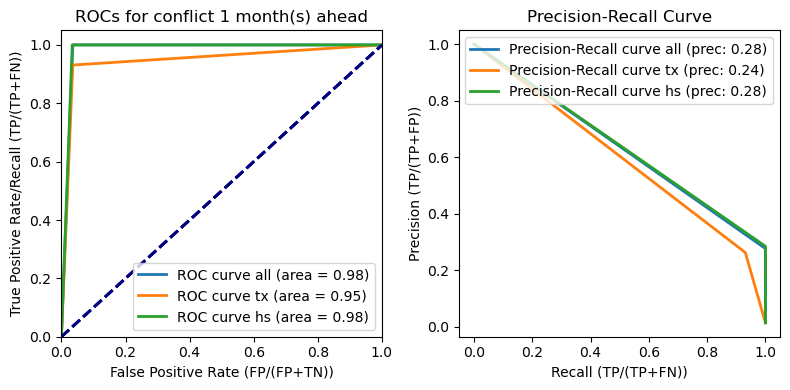

- - - - -- - - - - - - - - - - - - - - - - - - - - - 
conflict f_2
ROC: 0.98 Precision: 0.289
ROC: 0.921 Precision: 0.223
ROC: 0.98 Precision: 0.282


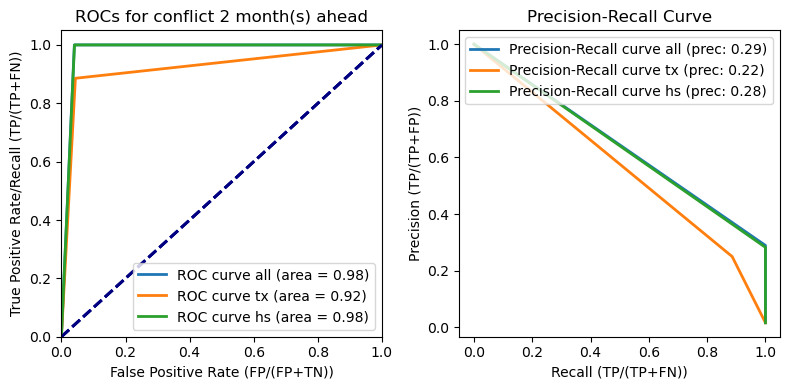

- - - - -- - - - - - - - - - - - - - - - - - - - - - 


In [511]:
for target in [target_clsf]:
    for sft in [1,2]:
        print(target, f'f_{sft}') #, model)
        get_roc_pr(pred_all_clsf, sft, target, ['all', 'tx', 'hs'], start_month_year, True, True)
        print('- - - - -- - - - - - - - - - - - - - - - - - - - - - ')